In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: make plots look nicer
sns.set(style="whitegrid", palette="muted", font_scale=1.1)


In [90]:
# 1. Load JSONL
df = pd.read_json("../data/processed_articles (2).jsonl", lines=True)

# 2. Quick look
print(df.shape)
print(df.columns.tolist())
df.head(3)


(25963, 6)
['date', 'title', 'overall_sentiment', 'overall_confidence', 'tickers', 'sectors']


,date,title,overall_sentiment,overall_confidence,tickers,sectors
0,2025-05-20 12:30:00+00:00,KOIL Energy Reports First Quarter 2025 Results,Neutral,0.000000,[],[]
1,2025-05-19 08:00:00+00:00,Niu Technologies Announces Unaudited First Qua...,Neutral,0.962612,"[{'symbol': 'AI', 'score': 0.077537545467754, ...","[{'sector': 'Unknown', 'score': 0.077537545467..."
2,2025-05-15 04:04:00+00:00,VEON 1Q25 Earnings Release: Strong Start to 20...,Neutral,0.960733,"[{'symbol': 'AI', 'score': 0.06375410959233001...","[{'sector': 'Unknown', 'score': 0.063754109592..."


In [91]:
tickers = df["tickers"].explode().dropna().apply(lambda x: x["symbol"])
count_A = (tickers == "A").sum()
print(f"Ticker 'A' appears {count_A} time(s) in the processed data.")

Ticker 'A' appears 21 time(s) in the processed data.


In [92]:
# 2. Compute how many have zero tickers
empty_tickers = (df["tickers"].map(len) == 0).sum()
total = len(df)
print(f"Number of articles with zero tickers: {empty_tickers} out of {total} ({(empty_tickers / total) * 100:.2f}%)")

Number of articles with zero tickers: 827 out of 25963 (3.19%)


In [93]:
df_filtered = df[df["tickers"].map(len) > 0].reset_index(drop=True)

In [94]:
# 3. Column types + missingness
schema = pd.DataFrame({
    "column":     df_filtered.columns,
    "dtype":      df_filtered.dtypes.astype(str),
    "missing":    df_filtered.isna().sum(),
    "pct_missing": (df_filtered.isna().mean()*100).round(2)
})
schema


,column,dtype,missing,pct_missing
date,date,"datetime64[ns, UTC]",0,0.0
title,title,object,0,0.0
overall_sentiment,overall_sentiment,object,0,0.0
overall_confidence,overall_confidence,float64,0,0.0
tickers,tickers,object,0,0.0
sectors,sectors,object,0,0.0


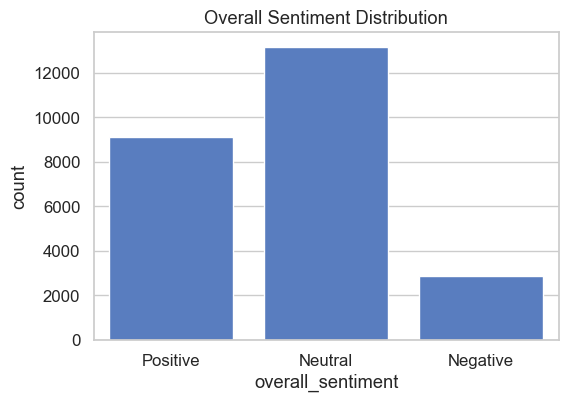

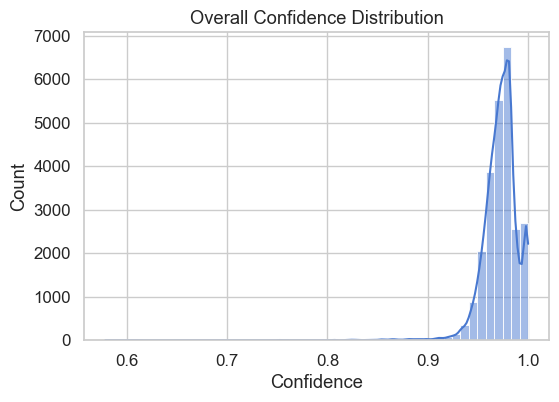

In [95]:
plt.figure(figsize=(6,4))
sns.countplot(x="overall_sentiment", data=df_filtered, order=["Positive","Neutral","Negative"])
plt.title("Overall Sentiment Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(df_filtered["overall_confidence"], bins=50, kde=True)
plt.title("Overall Confidence Distribution")
plt.xlabel("Confidence")
plt.show()


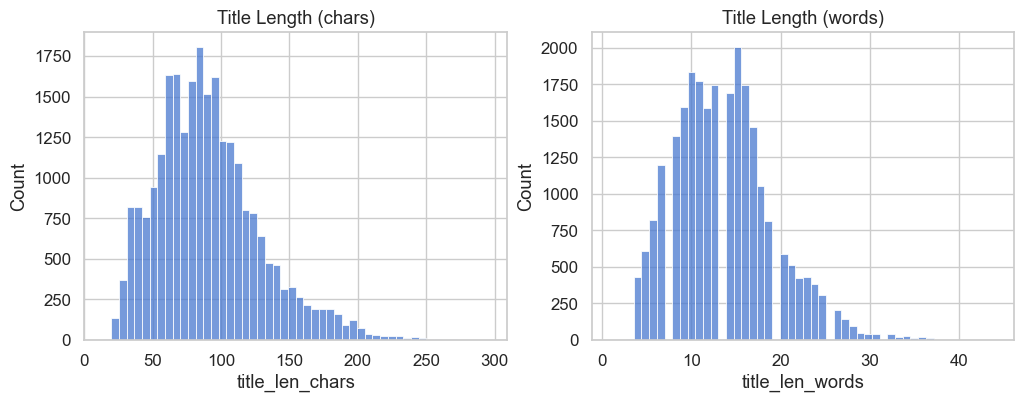

In [96]:
df_filtered["title_len_chars"] = df_filtered["title"].str.len()
df_filtered["title_len_words"] = df_filtered["title"].str.split().map(len)

fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.histplot(df_filtered["title_len_chars"], bins=50, ax=axes[0])
axes[0].set_title("Title Length (chars)")
sns.histplot(df_filtered["title_len_words"], bins=50, ax=axes[1])
axes[1].set_title("Title Length (words)")
plt.show()


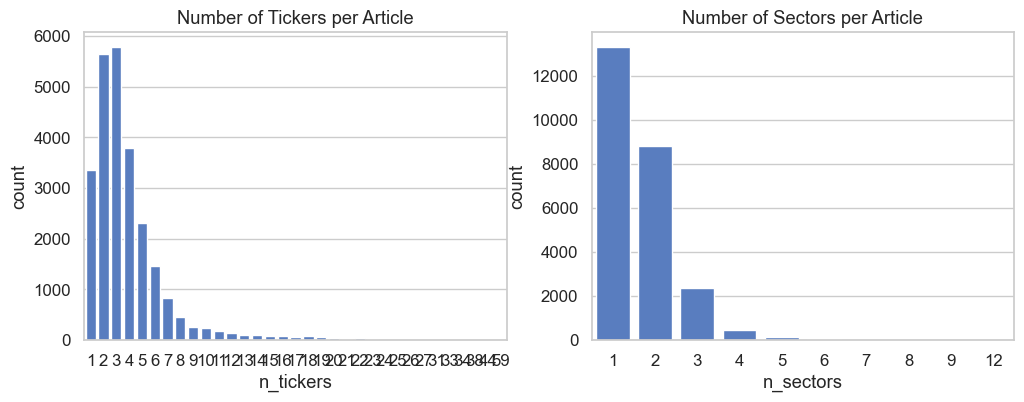

In [97]:
df_filtered["n_tickers"] = df_filtered["tickers"].map(len)
df_filtered["n_sectors"] = df_filtered["sectors"].map(len)

fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.countplot(x="n_tickers", data=df_filtered, ax=axes[0])
axes[0].set_title("Number of Tickers per Article")
sns.countplot(x="n_sectors", data=df_filtered, ax=axes[1])
axes[1].set_title("Number of Sectors per Article")
plt.show()


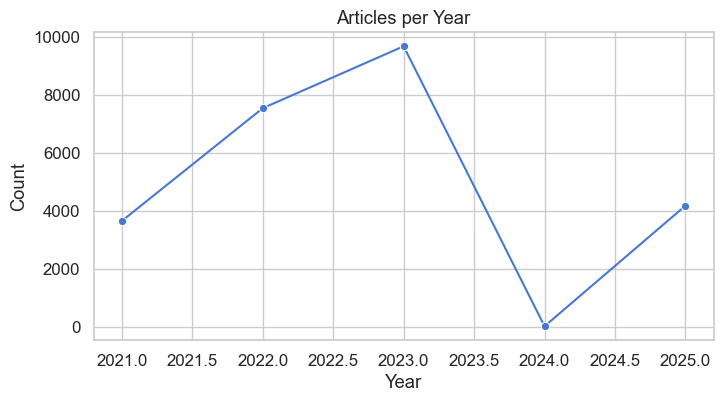

In [98]:
df_filtered["date"] = pd.to_datetime(df_filtered["date"])
yearly = df_filtered["date"].dt.year.value_counts().sort_index()

plt.figure(figsize=(8,4))
sns.lineplot(x=yearly.index, y=yearly.values, marker="o")
plt.title("Articles per Year")
plt.ylabel("Count")
plt.xlabel("Year")
plt.show()


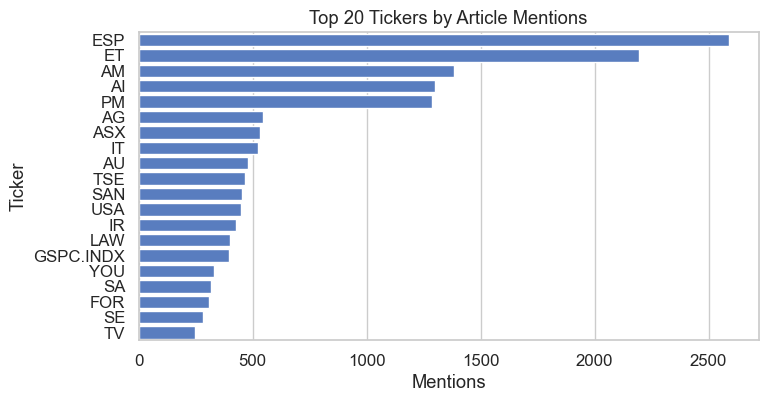

In [99]:
# 3.1 Flatten ticker list
tickers_flat = df_filtered["tickers"].explode().dropna().apply(pd.Series)

# 3.2 Top 20 tickers by article frequency
top20 = tickers_flat["symbol"].value_counts().head(20)
plt.figure(figsize=(8,4))
sns.barplot(x=top20.values, y=top20.index)
plt.title("Top 20 Tickers by Article Mentions")
plt.xlabel("Mentions")
plt.ylabel("Ticker")
plt.show()


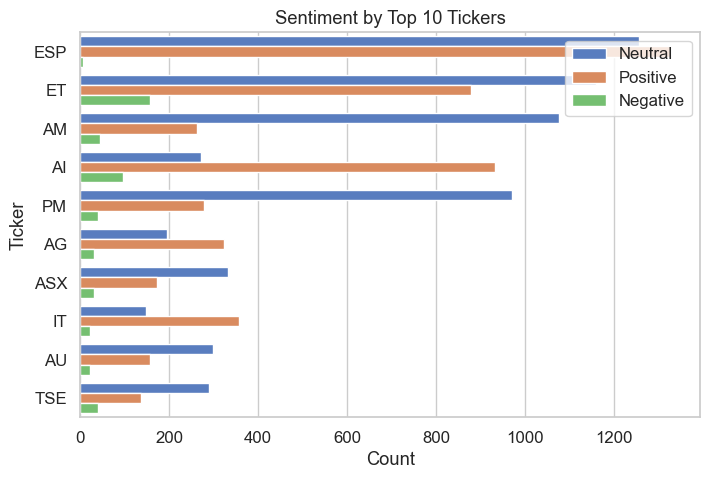

In [100]:
# 3.3 Sentiment breakdown per ticker (for top 10)
top_list = top20.index.tolist()[:10]
sub = tickers_flat[tickers_flat["symbol"].isin(top_list)]
plt.figure(figsize=(8,5))
sns.countplot(y="symbol", hue="label", data=sub, order=top_list)
plt.title("Sentiment by Top 10 Tickers")
plt.xlabel("Count")
plt.ylabel("Ticker")
plt.legend(loc="upper right")
plt.show()


In [101]:
# 3.4 Normalized sentiment ratio per ticker
ratio = (sub
         .groupby(["symbol","label"])
         .size()
         .unstack(fill_value=0)
         .pipe(lambda df2: df2.div(df2.sum(axis=1), axis=0)))
ratio.loc[top_list]


label,Negative,Neutral,Positive
symbol,,,
ESP,0.002704,0.484743,0.512553
ET,0.071103,0.528259,0.400638
AM,0.031815,0.778019,0.190166
AI,0.073190,0.208783,0.718028
PM,0.030280,0.753882,0.215839
AG,0.058394,0.354015,0.587591
ASX,0.056180,0.619850,0.323970
IT,0.039924,0.281369,0.678707
AU,0.048017,0.624217,0.327766


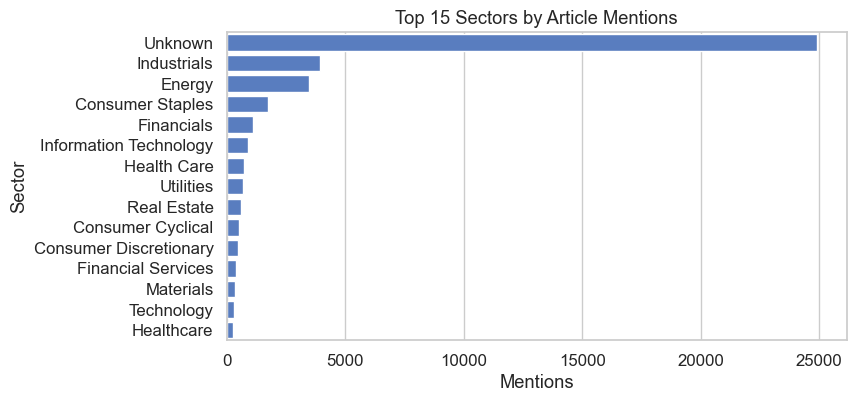

In [102]:
# 4.1 Flatten sectors
sectors_flat = pd.DataFrame(
	df_filtered["sectors"].explode().dropna().tolist()
)

# 4.2 Top sectors by mentions
topsec = sectors_flat["sector"].value_counts().head(15)
plt.figure(figsize=(8,4))
sns.barplot(x=topsec.values, y=topsec.index)
plt.title("Top 15 Sectors by Article Mentions")
plt.xlabel("Mentions")
plt.ylabel("Sector")
plt.show()


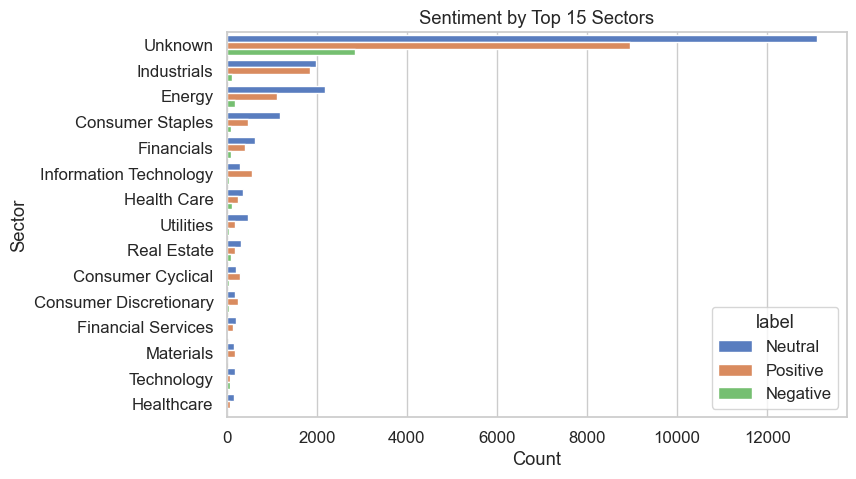

In [103]:
# 4.3 Sentiment breakdown for major sectors
maj = topsec.index.tolist()
sec_sub = sectors_flat[sectors_flat["sector"].isin(maj)]
plt.figure(figsize=(8,5))
sns.countplot(y="sector", hue="label", data=sec_sub, order=maj)
plt.title("Sentiment by Top 15 Sectors")
plt.xlabel("Count")
plt.ylabel("Sector")
plt.show()


In [104]:
# 4.4 Normalized sector sentiment ratios
ratio_sec = (sec_sub
             .groupby(["sector","label"])
             .size()
             .unstack(fill_value=0)
             .pipe(lambda df2: df2.div(df2.sum(axis=1), axis=0)))
ratio_sec.loc[maj]


label,Negative,Neutral,Positive
sector,,,
Unknown,0.114402,0.526183,0.359416
Industrials,0.030648,0.500253,0.469098
Energy,0.051481,0.625539,0.322980
Consumer Staples,0.049625,0.683208,0.267167
Financials,0.077540,0.551693,0.370766
Information Technology,0.053333,0.332222,0.614444
Health Care,0.160167,0.491643,0.348189
Utilities,0.058993,0.683453,0.257554
Real Estate,0.177665,0.524535,0.297800


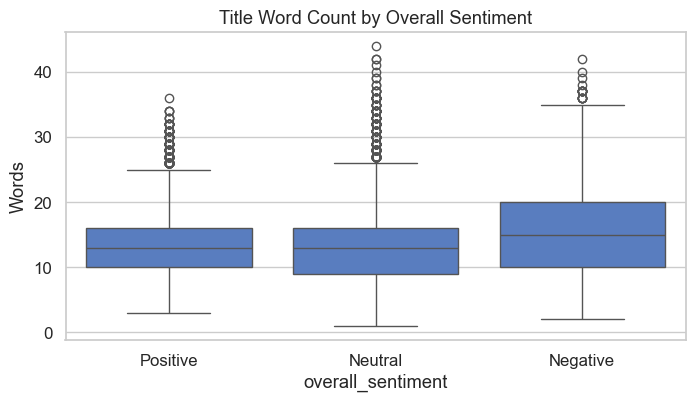

In [105]:
# Boxplot of title length by sentiment
plt.figure(figsize=(8,4))
sns.boxplot(x="overall_sentiment", y="title_len_words", data=df_filtered,
            order=["Positive","Neutral","Negative"])
plt.title("Title Word Count by Overall Sentiment")
plt.ylabel("Words")
plt.show()


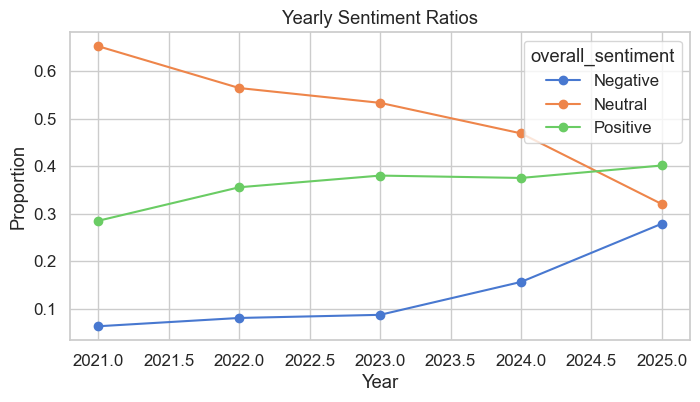

In [106]:
time_sent = (df_filtered
             .groupby([df_filtered["date"].dt.year, "overall_sentiment"])
             .size()
             .unstack(fill_value=0)
             .pipe(lambda x: x.div(x.sum(axis=1), axis=0)))
time_sent.plot(kind="line", marker="o", figsize=(8,4))
plt.title("Yearly Sentiment Ratios")
plt.ylabel("Proportion")
plt.xlabel("Year")
plt.show()


In [107]:
# Standard deviation of sentiment ratio across years
ticker_year = tickers_flat.copy()
ticker_year["year"] = df_filtered["date"].repeat(df_filtered["tickers"].str.len()).values
ty = (ticker_year
      .groupby(["symbol","year","label"])
      .size()
      .unstack(fill_value=0)
      .groupby(level=0)
      .apply(lambda d: d.div(d.sum(axis=1), axis=0))
      .groupby(level=0)
      .std())
ty["Positive"].sort_values(ascending=False).head(10)


symbol
01K.F         0.707107
002594.SHE    0.707107
BIRDF.US      0.707107
06S.F         0.707107
03M.F         0.707107
ZWS           0.707107
HIP.F         0.707107
HIJ2.F        0.707107
ZTF.LSE       0.707107
ERE.F         0.707107
Name: Positive, dtype: float64